From Eastwood ([doi:10.1371/journal.pone.0162388](https://doi.org/10.1371/journal.pone.0162388)
>When developing the incidence algorithms intended for secondary care data, we defined incident diabetes type based on ICD-10 codes (E10 = type 1 diabetes, E11 = type 2 diabetes, E13/E14 = unspecified diabetes). Prevalent diabetes was excluded as above.

>For both primary and secondary care incidence algorithms, we derived event dates by taking the mid-point between the last primary care consultation/ hospital admission without diabetes and the date of the first diabetes Read code/ ICD code/ diabetes medication/ hyperglycaemic blood test/ fifth process of care code. If there were no previous consultations or admissions, we used the UK Biobank inception date. The date of the first diabetes Read code/ ICD code/ diabetes medication/ hyperglycaemic blood test/ fifth process of care code will be available to researchers separately if they wish to calculate the event date in an alternative manner.

<img src="https://journals.plos.org/plosone/article/figure/image?size=large&id=info:doi/10.1371/journal.pone.0162388.g003"
     alt="Eastwood Figure 3"
     style="float: left; margin-right: 10px;" />
     
Additional codings for complications are sourced for HDR-UK from: https://portal.caliberresearch.org/phenotypes/kuan-diabetes-bymfsbeu7tvb6ykrq8abvk


In [7]:
import pandas as pd
import numpy as np
import json
import csv
from datetime import date
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()

In [17]:
icd10_diabetes =  {
    'T1D' : 'E10',
    'T2D' : 'E11',
    'Diabetes_unspecified' : ['E13', 'E14'],
    'Diabetes_secondary_malnutrition' : 'E12',
    'Diabetes_secondary_malnutrition_pregnancy' : 'O242',
    'Diabetes_unspecified_mononeuropathy' : 'G590',
    'Diabetes_unspecified_polyneuropathy' : 'G632',
    'Diabetes_unspecified_cataract' : 'H280',
    'Diabetes_unspecified_retinopathy' : 'H360',
    'Diabetes_unspecified_arthropathy' : 'M142',
    'Diabetes_unspecified_glomerulardisorders' : 'N083',
    'Diabetes_unspecified_pregnancy_preexistingT1D' : 'O240',
    'Diabetes_unspecified_pregnancy_preexistingT2D' : 'O241',
    'Diabetes_unspecified_pregnancy_preexistingUnspecified' : 'O243'
                  }

# Taken from Phecodes (https://phewascatalog.org/phecodes)
icd9_diabetes = {
    'T1D' : ['25001','25003','25021','25023','25031','25033','25081','25083','25091','25093','25011','25013','25041','25043','25051','25053','25061','25063','25071'], # Phecode=250.1
    'T2D' : ['250','25002','2502','25022','2503','25032','2508','25082','2509','25092'], # Phecode=250.2
    'ANY' : ['250', '2500', '2501', '2502', '2503', '2504', '2505', '2506', '2507', '2508', '2509'] # Phecode=250
}

loc_withdrawals = '/rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/pre_qc_data/Withdrawals/w7439_20210201.csv'
loc_deaths = '/rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/pre_qc_data/Death/death_20210221.txt'
loc_causeofdeath = '/rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/pre_qc_data/Death/death_cause_20210221.txt'
loc_hes_dates = '/rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/pre_qc_data/HES/hesin_20210406.txt'
loc_hes_diagnoses = '/rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/pre_qc_data/HES/hesin_diag_20210406.txt'
loc_hes_operations = '/rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/pre_qc_data/HES/hesin_oper_20210406.txt'

## Parse Death registry

In [3]:
deaths = pd.read_table(loc_deaths, index_col=['eid', 'ins_index'])
deaths['date_of_death'] = pd.to_datetime(deaths['date_of_death'], format='%d/%m/%Y')
print('Deaths:')
deaths.head()

Deaths:


,,dsource,source,date_of_death
eid,ins_index,,,
1000178,0,SCOT,55,2019-08-15
1000494,0,E/W,52,2020-05-30
1000515,0,E/W,2,2015-03-01
1001270,0,E/W,2,2019-12-04
1001283,0,SCOT,19,2013-09-17


In [4]:
causeofdeath = pd.read_table(loc_causeofdeath, index_col=['eid', 'ins_index'])
print('Causes:')
causeofdeath.head()

Causes:


arr_index  level cause_icd10
eid     ins_index                              
1000178 0                  0      1        G318
        0                  1      2         G20
        0                  2      2        I258
        0                  3      2        S720
        0                  4      2         W19

In [5]:
for cause, icdcodes in icd10_diabetes.items():
    print(cause, icdcodes)
    deaths[cause] = np.nan
    if type(icdcodes) is list:
        cause_secondary = set(causeofdeath.loc[causeofdeath['cause_icd10'].str.startswith(tuple(icdcodes)) & (causeofdeath['arr_index'] != 0)].index)
        cause_primary = set(causeofdeath.loc[causeofdeath['cause_icd10'].str.startswith(tuple(icdcodes)) & (causeofdeath['arr_index'] == 0)].index)
    else:
        cause_secondary = set(causeofdeath.loc[causeofdeath['cause_icd10'].str.startswith(icdcodes) & (causeofdeath['arr_index'] != 0)].index)
        cause_primary = set(causeofdeath.loc[causeofdeath['cause_icd10'].str.startswith(icdcodes) & (causeofdeath['arr_index'] == 0)].index)

    if (len(cause_secondary) > 0) or (len(cause_primary) > 0):
        deaths[cause] = 0
        deaths.loc[cause_secondary, cause] = 2 # Secondary
        deaths.loc[cause_primary, cause] = 1 # Primary 
        print(deaths[cause].value_counts())

deaths.to_csv('DiseaseEvents_Diabetes_Deaths.csv')
deaths.head()

T1D E10
0    33923
2      117
1       23
Name: T1D, dtype: int64
T2D E11
0    32561
2     1385
1      117
Name: T2D, dtype: int64
Diabetes_unspecified ['E13', 'E14']
0    33125
2      843
1       95
Name: Diabetes_unspecified, dtype: int64
Diabetes_secondary_malnutrition E12
Diabetes_secondary_malnutrition_pregnancy O242
Diabetes_unspecified_mononeuropathy G590
Diabetes_unspecified_polyneuropathy G632
Diabetes_unspecified_cataract H280
Diabetes_unspecified_retinopathy H360
Diabetes_unspecified_arthropathy M142
Diabetes_unspecified_glomerulardisorders N083
Diabetes_unspecified_pregnancy_preexistingT1D O240
Diabetes_unspecified_pregnancy_preexistingT2D O241
Diabetes_unspecified_pregnancy_preexistingUnspecified O243


,,dsource,source,date_of_death,T1D,T2D,Diabetes_unspecified,Diabetes_secondary_malnutrition,Diabetes_secondary_malnutrition_pregnancy,Diabetes_unspecified_mononeuropathy,Diabetes_unspecified_polyneuropathy,Diabetes_unspecified_cataract,Diabetes_unspecified_retinopathy,Diabetes_unspecified_arthropathy,Diabetes_unspecified_glomerulardisorders,Diabetes_unspecified_pregnancy_preexistingT1D,Diabetes_unspecified_pregnancy_preexistingT2D,Diabetes_unspecified_pregnancy_preexistingUnspecified
eid,ins_index,,,,,,,,,,,,,,,,,
1000178,0,SCOT,55,2019-08-15,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000494,0,E/W,52,2020-05-30,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000515,0,E/W,2,2015-03-01,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001270,0,E/W,2,2019-12-04,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001283,0,SCOT,19,2013-09-17,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Parse Secondary Care data (HES)

In [9]:
# Load HES data
hes_dates = pd.read_table(loc_hes_dates, index_col=['eid', 'ins_index'])
hes_diagnoses = pd.read_table(loc_hes_diagnoses, index_col=['eid', 'ins_index'])

hes_dates['epistart'] = pd.to_datetime(hes_dates['epistart'], format='%d/%m/%Y')
hes_dates['epiend'] = pd.to_datetime(hes_dates['epiend'], format='%d/%m/%Y')
hes_dates['elecdate'] = pd.to_datetime(hes_dates['elecdate'], format='%d/%m/%Y')
hes_dates['admidate'] = pd.to_datetime(hes_dates['admidate'], format='%d/%m/%Y')
hes_dates['disdate'] = pd.to_datetime(hes_dates['disdate'], format='%d/%m/%Y')

# hes_operations = pd.read_table(loc_hes_operations, index_col=['eid', 'ins_index'])
# hes_operations['opdate'] = pd.to_datetime(hes_operations['opdate'], format='%d/%m/%Y')

/home/sl925/jupyter-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (25,28,32,40) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/sl925/jupyter-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
# Choose best date to use for HES data
# epistart > admidate
#hes_dates['mindate'] = hes_dates[['epistart', 'epiend', 'elecdate', 'admidate', 'disdate']].min(axis=1)
hes_dates['event_date'] = hes_dates['epistart'] 
hes_dates.loc[(hes_dates['event_date'].isnull()) & (hes_dates['admidate'].isnull() == False), 'event_date'] = hes_dates.loc[(hes_dates['event_date'].isnull()) & (hes_dates['admidate'].isnull() == False), 'admidate']
print(hes_dates.loc[hes_dates['event_date'].isnull()].shape[0], 'rows missing event dates')

42 rows missing event dates


In [11]:
# Find latest HES record 
def MaxHES_Nation(df):
    idxmax = df['event_date'].idxmax()
    if pd.isnull(idxmax):
        dsources = list(set(extract['dsource']))
        if len(dsources) == 1:
            return pd.Series([dsources[0], np.nan])
        else:
            return pd.Series([np.nan, np.nan])
    else:
        return pd.Series(list(df.loc[idxmax, ['dsource', 'event_date']]))
hes_dates.groupby('eid').progress_apply(MaxHES_Nation).to_csv('HES_MaxRecord.csv')

  0%|          | 0/439461 [00:00<?, ?it/s]

NameError: name 'extract' is not defined

In [32]:
diags_icd9 = hes_diagnoses[hes_diagnoses['diag_icd9'].str.startswith('250', na=False)]
print('Unique EIDs (ICD-9):', len(set(diags_icd9.index.get_level_values('eid'))))
diags_icd9 = diags_icd9.merge(hes_dates[['event_date']], left_index=True,right_index=True)
diags_icd9['phenotype'] = 'Diabetes_unspecified'
for phenotype in ['T2D', 'T1D']:
    icd9_match_TF = diags_icd9['diag_icd9'].str.startswith(tuple(icd9_diabetes[phenotype]), na=False)
    diags_icd9.loc[icd9_match_TF, 'phenotype'] = phenotype
diags_icd9['event_primary'] = (diags_icd9['level'] == 1)
diags_icd9 = diags_icd9[['phenotype', 'diag_icd10', 'event_primary', 'event_date']]
diags_icd9['phenotype'].value_counts()

Unique EIDs (ICD-9): 143


T2D    480
T1D     36
Name: phenotype, dtype: int64

In [31]:
hes_diagnoses[hes_diagnoses['diag_icd9'].str.startswith(tuple(icd9_diabetes['T1D']), na=False)]

arr_index  level diag_icd9  diag_icd9_nb diag_icd10  \
eid     ins_index                                                        
1324022 4                  1      2     25001           NaN        NaN   
        5                  1      2     25001           NaN        NaN   
1993441 4                  1      2     25011           NaN        NaN   
2132550 2                  5      2     25001           NaN        NaN   
2219508 5                  0      1     25011           NaN        NaN   
        7                  0      1     25001           NaN        NaN   
2265807 7                  1      2     25001           NaN        NaN   
2635401 9                  2      2     25001           NaN        NaN   
        2                  0      1     25001           NaN        NaN   
        1                  0      1     25001           NaN        NaN   
        13                 0      1     25001           NaN        NaN   
        10                 4      2     25001           NaN        NaN   
2882095 0                  0      1     25001           NaN        NaN   
3003461 2                  0      1     25001           NaN        NaN   
        1                  0      1     25001           NaN        NaN   
3025017 7                  0      1     25001           NaN        NaN   
        11                 2      2     25001           NaN        NaN   
3384885 1                  0      1     25001           NaN        NaN   
        6                  0      1     25001           NaN        NaN   
        3                  2      2     25001           NaN        NaN   
        2                  1      2     25001           NaN        NaN   
        4                  1      2     25001           NaN        NaN   
        5                  0      1     25001           NaN        NaN   
3994882 2                  1      2     25001           NaN        NaN   
        1                  2      2     25001           NaN        NaN   
4500999 6                  1      2     25001           NaN        NaN   
4757148 2                  1      2     25001           NaN        NaN   
5182754 1                  0      1     25011           NaN        NaN   
5220072 18                 0      1     25001           NaN        NaN   
        16                 0      1     25001           NaN        NaN   
        15                 0      1     25001           NaN        NaN   
        14                 0      1     25001           NaN        NaN   
        0                  0      1     25001           NaN        NaN   
5437062 0                  0      1     25001           NaN        NaN   
5494873 1                  0      1     25001           NaN        NaN   
        2                  0      1     25001           NaN        NaN   

                   diag_icd10_nb  
eid     ins_index                 
1324022 4                    NaN  
        5                    NaN  
1993441 4                    NaN  
2132550 2                    NaN  
2219508 5                    NaN  
        7                    NaN  
2265807 7                    NaN  
2635401 9                    NaN  
        2                    NaN  
        1                    NaN  
        13                   NaN  
        10                   NaN  
2882095 0                    NaN  
3003461 2                    NaN  
        1                    NaN  
3025017 7                    NaN  
        11                   NaN  
3384885 1                    NaN  
        6                    NaN  
        3                    NaN  
        2                    NaN  
        4                    NaN  
        5                    NaN  
3994882 2                    NaN  
        1                    NaN  
4500999 6                    NaN  
4757148 2                    NaN  
5182754 1                    NaN  
5220072 18                   NaN  
        16                   NaN  
        15                   NaN  
        14                   NaN  
        0       

In [34]:
# DiseaseEvents = []
# h_DiseaseEvents = ['eid', 'ins_index', 'phenotype', 'diag_icd10', 'event_primary', 'event_date']

count = 0

## ICD-10
for phenotype, icdcodes in tqdm_notebook(icd10_diabetes.items()):
    print(phenotype, icdcodes) 
    if type(icdcodes) is list:
        diags = hes_diagnoses[hes_diagnoses['diag_icd10'].str.startswith(tuple(icdcodes), na=False)]
    else:
        diags = hes_diagnoses[hes_diagnoses['diag_icd10'].str.startswith(icdcodes, na=False)]
    
    print('Unique EIDs:', len(set(diags.index.get_level_values('eid'))))
    
    #Join with event dates
    diags = diags.merge(hes_dates[['event_date']], left_index=True,right_index=True)
    #for i, event in diags.iterrows():
    #    DiseaseEvents.append(list(i) + [phenotype, event['diag_icd10'], event['level'] == 1, event['event_date']])
    diags['phenotype'] = phenotype
    diags['event_primary'] = (diags['level'] == 1)
    diags = diags[['phenotype', 'diag_icd9', 'diag_icd10', 'event_primary', 'event_date']]
    
    if count == 0:
        DiseaseEvents = diags.copy()
    else:
        DiseaseEvents = pd.concat([DiseaseEvents, diags])
    
    count += 1

## Add ICD-9 (very rudimentary for prevalent case capture in Scotland)
diags_icd9 = hes_diagnoses[hes_diagnoses['diag_icd9'].str.startswith('250', na=False)]
print('Unique EIDs (ICD-9):', len(set(diags_icd9.index.get_level_values('eid'))))
diags_icd9 = diags_icd9.merge(hes_dates[['event_date']], left_index=True,right_index=True)
diags_icd9['phenotype'] = 'Diabetes_unspecified'
for phenotype in ['T2D', 'T1D']:
    icd9_match_TF = diags_icd9['diag_icd9'].str.startswith(tuple(icd9_diabetes[phenotype]), na=False)
    diags_icd9.loc[icd9_match_TF, 'phenotype'] = phenotype
diags_icd9['event_primary'] = (diags_icd9['level'] == 1)
diags_icd9 = diags_icd9[['phenotype', 'diag_icd9', 'diag_icd10', 'event_primary', 'event_date']]
#diags_icd9['phenotype'].value_counts()
DiseaseEvents = pd.concat([DiseaseEvents, diags_icd9])
          
# df_DiseaseEvents = pd.DataFrame(DiseaseEvents, columns=h_DiseaseEvents)
# df_DiseaseEvents.sort_values(['eid','event_date'], inplace = True)
DiseaseEvents.to_csv('DiseaseEvents_Diabetes_HES.csv', index=False)
DiseaseEvents.head()

  0%|          | 0/14 [00:00<?, ?it/s]

T1D E10
Unique EIDs: 4793
T2D E11
Unique EIDs: 38992
Diabetes_unspecified ['E13', 'E14']
Unique EIDs: 5832
Diabetes_secondary_malnutrition E12
Unique EIDs: 7
Diabetes_secondary_malnutrition_pregnancy O242
Unique EIDs: 0
Diabetes_unspecified_mononeuropathy G590
Unique EIDs: 355
Diabetes_unspecified_polyneuropathy G632
Unique EIDs: 1203
Diabetes_unspecified_cataract H280
Unique EIDs: 75
Diabetes_unspecified_retinopathy H360
Unique EIDs: 3609
Diabetes_unspecified_arthropathy M142
Unique EIDs: 27
Diabetes_unspecified_glomerulardisorders N083
Unique EIDs: 705
Diabetes_unspecified_pregnancy_preexistingT1D O240
Unique EIDs: 69
Diabetes_unspecified_pregnancy_preexistingT2D O241
Unique EIDs: 14
Diabetes_unspecified_pregnancy_preexistingUnspecified O243
Unique EIDs: 2
Unique EIDs (ICD-9): 143


phenotype diag_icd9 diag_icd10  event_primary event_date
eid     ins_index                                                         
1000262 9               T1D       NaN       E104          False 2015-01-14
        9               T1D       NaN       E104          False 2015-01-14
        9               T1D       NaN       E103          False 2015-01-14
        10              T1D       NaN       E104          False 2020-01-03
        10              T1D       NaN       E103          False 2020-01-03

In [35]:
# Define the fist coded diabetes event (from HES)
DiseaseEvents_HES_annotated = DiseaseEvents.loc[DiseaseEvents['phenotype'].isin(['T1D', 'T2D', 'Diabetes_unspecified']),].copy()
DiseaseEvents_HES_annotated['FirstEvent'] = False
DiseaseEvents_HES_annotated.loc[DiseaseEvents_HES_annotated.groupby('eid')['event_date'].idxmin(skipna=False), 'FirstEvent'] = True

hes_dates_eids = hes_dates.index.get_level_values(0)

# Find previous diabetes free HES-event for cases ('event_date_PreviousDiabetesFree')
# for eid, diabetes_events in tqdm_notebook(DiseaseEvents_HES_annotated[DiseaseEvents_HES_annotated['FirstEvent'] == True].groupby('eid')):
#     DiseaseEvents_HES_annotated.loc[diabetes_events.index, 'HES_PreviousDiabetesFreeEvent'] = hes_dates.loc[(hes_dates_eids == eid) & (hes_dates['event_date'] < diabetes_events['event_date'].min()), 'event_date'].max()
def FindDiseaseFree(df):
    df_diseasefreedate = pd.DataFrame(index=df.index)
    df_diseasefreedate['HES_PreviousDiabetesFreeEvent'] = hes_dates.loc[(hes_dates_eids == df.name) & (hes_dates['event_date'] < df['event_date'].min()), 'event_date'].max()
    return(df_diseasefreedate)
DiseaseEvents_HES_annotated = DiseaseEvents_HES_annotated.join(DiseaseEvents_HES_annotated[DiseaseEvents_HES_annotated['FirstEvent'] == True].groupby('eid').progress_apply(FindDiseaseFree))

DiseaseEvents_HES_annotated.to_csv('DiseaseEvents_Diabetes_HES_annotated.csv')


  0%|          | 0/41322 [00:00<?, ?it/s]

In [36]:
DiseaseEvents_HES_annotated

phenotype diag_icd9 diag_icd10  event_primary event_date  \
eid     ins_index                                                            
1000083 1               T2D       NaN       E119          False 2010-08-15   
        15              T2D       NaN       E119          False 2012-04-04   
        16              T2D       NaN       E119          False 2012-04-19   
        18              T2D       NaN       E119          False 2012-08-05   
        23              T2D       NaN       E119          False 2011-09-20   
...                     ...       ...        ...            ...        ...   
6026629 10              T2D       NaN       E119          False 2015-06-17   
        11              T2D       NaN       E119          False 2015-10-07   
        12              T2D       NaN       E119          False 2015-12-17   
        14              T2D       NaN       E119          False 2015-06-14   
        15              T2D       NaN       E119          False 2015-10-26   

                   FirstEvent HES_PreviousDiabetesFreeEvent  
eid     ins_index                                            
1000083 1                True                    2009-11-05  
        15              False                           NaT  
        16              False                           NaT  
        18              False                           NaT  
        23              False                           NaT  
...                       ...                           ...  
6026629 10              False                           NaT  
        11              False                           NaT  
        12              False                           NaT  
        14              False                           NaT  
        15              False                           NaT  

[309552 rows x 7 columns]

In [37]:
# Find previous max HES event for people with no recorded diabetes in HES ('event_date_PreviousDiabetesFree')
eids_diabetesfree = set(hes_dates_eids).difference(DiseaseEvents_HES_annotated.index.get_level_values(0))
hes_maxdate_diabetesfree = hes_dates.loc[hes_dates.index.get_level_values(0).isin(eids_diabetesfree)].groupby('eid')['event_date'].max()
hes_maxdate_diabetesfree.to_csv('DiabetesFree_HES_maxrecord.csv')
hes_maxdate_diabetesfree.head()

eid
1000012   2014-12-29
1000026   2016-11-23
1000031   2013-10-04
1000045   2013-10-24
1000067   2009-01-26
Name: event_date, dtype: datetime64[ns]

## Parse Primary Care data

In [3]:
loc_gp_registrations = '/rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/pre_qc_data/PrimaryCare/gp_registrations_20191011.txt'
loc_gp_records = '/rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/pre_qc_data/PrimaryCare/gp_clinical_20191011.txt'

! wc -l /rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/pre_qc_data/PrimaryCare/gp_clinical_20191011_truncated.csv
#! wc -l /rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/pre_qc_data/PrimaryCare/gp_clinical_20191011.txt

123669372 /rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/pre_qc_data/PrimaryCare/gp_clinical_20191011_truncated.csv


## Read records and define diabetes events

In [4]:
# Read records (line-by-line)
gp_records = []

with open(loc_gp_records, 'r', encoding='unicode_escape') as infile:
    h = infile.readline().strip().split('\t')
    print(h)
    for line in tqdm_notebook(infile, total=123669372): 
        # Parse Date
        event = {k:v for (k,v) in zip(h, [x.strip() for x in line.split('\t')])}
        if event['event_dt'] == '':
            event['event_dt'] = None
        else:
            event['event_dt'] = date(*[int(x) for x in event['event_dt'].split('/')][::-1])
        gp_records.append(event)
        
gp_records = pd.DataFrame(gp_records)
gp_records.event_dt = pd.to_datetime(gp_records.event_dt)
#gp_records = gp_records.sort_values(['eid', 'event_dt'], ascending=True)
#gp_records = gp_records.set_index(['eid', 'event_dt'])
gp_records.head()

['eid', 'data_provider', 'event_dt', 'read_2', 'read_3', 'value1', 'value2', 'value3']


  0%|          | 0/123669372 [00:00<?, ?it/s]

,eid,data_provider,event_dt,read_2,read_3,value1,value2,value3
0,1000012,3,1993-10-13,,XE2MO,,,
1,1000012,3,1994-05-06,,XE2MO,,,
2,1000012,3,1994-08-05,,1383.,,,
3,1000012,3,1994-08-05,,229..,1.600,,
4,1000012,3,1994-08-05,,22A..,94.780,,


In [5]:
# Define diabetes events w/ Read2 Codes
gp_codes_read2_prefix = {
    'C10E' : 'T1D',
    'C10F' : 'T2D'    
} # Any code that starts with C10 is a diabetes code (e.g. Diabetes_unspecified)

gp_records.loc[gp_records['read_2'].str.startswith('C10'), 'phenotype'] = 'Diabetes_unspecified'

for read2_prefix, pheno in gp_codes_read2_prefix.items():
    gp_records.loc[gp_records['read_2'].str.startswith(read2_prefix), 'phenotype'] = pheno

# Event Counts
read2_diabetes_counts = gp_records.loc[(gp_records.phenotype.isnull() == False) & (gp_records.read_2 != ''), 'read_2'].value_counts()
read2_diabetes_counts.name = 'event_ct'
read2_diabetes_counts = pd.DataFrame(read2_diabetes_counts)
# Person Counts
read2_diabetes_counts['eid_ct'] = 0
for read2_code in read2_diabetes_counts.index:
    read2_diabetes_counts.loc[read2_code, 'eid_ct'] = len(set(gp_records.loc[gp_records['read_2'] == read2_code, 'eid']))

# Phenotype
read2_diabetes_counts['phenotype'] = 'Diabetes_unspecified'
for read2_prefix, pheno in gp_codes_read2_prefix.items():
    read2_diabetes_counts.loc[[x.startswith(read2_prefix) for x in read2_diabetes_counts.index], 'phenotype'] = pheno
    
read2_diabetes_counts 

,event_ct,eid_ct,phenotype
C10F.,19983,5382,T2D
C10..,4116,1682,Diabetes_unspecified
C109.,1812,809,Diabetes_unspecified
C10E.,720,272,T1D
C1001,595,277,Diabetes_unspecified
...,...,...,...
C10yz,1,1,Diabetes_unspecified
C10z.,1,1,Diabetes_unspecified
C10ED,1,1,T1D
C10J.,1,1,Diabetes_unspecified


In [6]:
with open('diabetes_read3.json', 'r') as json_in:
    gp_codes_read3 = json.load(json_in)
print(gp_codes_read3)

gp_records.loc[gp_records['read_3'].isin(gp_codes_read3.keys()), 'phenotype'] = [gp_codes_read3.get(x)[1] for x in gp_records.loc[gp_records['read_3'].isin(gp_codes_read3.keys()), 'read_3']]

{'C10..': ['Diabetes mellitus', 'Diabetes_unspecified'], 'C100.': ['Diabetes mellitus with no mention of complication', 'Diabetes_unspecified'], 'C100z': ['Diabetes mellitus NOS with no mention of complication', 'Diabetes_unspecified'], 'C101.': ['Diabetes mellitus with ketoacidosis', 'Diabetes_unspecified'], 'C1010': ['Type 1 diabetes mellitus with ketoacidosis|Type 1 diabetes mellitus with ketoacidosis', 'T1D'], 'C1011': ['Type 2 diabetes mellitus with ketoacidosis|Type 2 diabetes mellitus with ketoacidosis', 'T2D'], 'C101y': ['Other specified diabetes mellitus with ketoacidosis', 'Diabetes_unspecified'], 'C101z': ['Diabetes mellitus NOS with ketoacidosis', 'Diabetes_unspecified'], 'C102.': ['Diabetes mellitus with hyperosmolar coma', 'Diabetes_unspecified'], 'C1020': ['Diabetes mellitus, juvenile type, with hyperosmolar coma', 'Diabetes_unspecified'], 'C1021': ['Diabetes mellitus, adult onset, with hyperosmolar coma', 'Diabetes_unspecified'], 'C102z': ['Diabetes mellitus NOS with hy

In [7]:
# Event Counts
read3_diabetes_counts = gp_records.loc[(gp_records.phenotype.isnull() == False) & (gp_records.read_3 != ''), 'read_3'].value_counts()
read3_diabetes_counts.name = 'event_ct'
read3_diabetes_counts = pd.DataFrame(read3_diabetes_counts)

# Person Counts
read3_diabetes_counts['eid_ct'] = 0
for read3_code in tqdm_notebook(read3_diabetes_counts.index):
    read3_diabetes_counts.loc[read3_code, 'eid_ct'] = len(set(gp_records.loc[gp_records['read_3'] == read3_code, 'eid']))

read3_diabetes_counts['phenotype'] = [gp_codes_read3.get(x)[1] for x in read3_diabetes_counts.index]
    
read3_diabetes_counts

  0%|          | 0/90 [00:00<?, ?it/s]

,event_ct,eid_ct,phenotype
X40J5,56364,12544,T2D
C10..,14941,4125,Diabetes_unspecified
X40J4,4719,887,T1D
X40J6,1530,585,T2D
X00Ag,720,473,Diabetes_unspecified
...,...,...,...
C10y.,1,1,Diabetes_unspecified
C103.,1,1,Diabetes_unspecified
C1041,1,1,Diabetes_unspecified
X40J7,1,1,Diabetes_unspecified


In [8]:
nrecords_diabetes = gp_records['phenotype'].value_counts().sum()
eid_w_diabetes = set(gp_records.loc[gp_records['phenotype'].isnull() == False, 'eid'])

print('{} diabetes events ({:.2f}% of all records) [{} ({:.2f}%) unique participants]'.format(nrecords_diabetes, 100*nrecords_diabetes/gp_records.shape[0], len(eid_w_diabetes), 100*len(eid_w_diabetes)/len(set(gp_records['eid']))))

109167 diabetes events (0.09% of all records) [19146 (8.32%) unique participants]


## Get summary data for each eid

In [45]:
def Process_GP(df):
    r = {
        'event_min' : df['event_dt'].min(),
        'event_max' : df['event_dt'].max(),
        'gp_Diabetes_any' : False,
        'gp_Diabetes_any.event_min' : None,
        'gp_Diabetes_any.maxdate_diabetesfree' : None
    }
    
    df_diabetes = df[df['phenotype'].isnull() == False]
    if df_diabetes.shape[0] > 0:
        r['gp_Diabetes_any'] = True
        r['gp_Diabetes_any.event_min'] = df_diabetes['event_dt'].min()
        r['gp_Diabetes_any.maxdate_diabetesfree'] = df.loc[df['event_dt'] < r['gp_Diabetes_any.event_min'], 'event_dt'].max()
    
    for pheno in ['Diabetes_unspecified', 'T1D', 'T2D']:
        if (r['gp_Diabetes_any'] is True) and (pheno in df_diabetes['phenotype'].values):
            r['gp_{}.event_min'.format(pheno)] = df_diabetes.loc[df_diabetes['phenotype'] == pheno, 'event_dt'].min()
        else:
            r['gp_{}.event_min'.format(pheno)] = None
            
    
    return pd.Series(r)

gp_records_defined = gp_records.groupby('eid').progress_apply(Process_GP)
gp_records_defined.to_csv('GP_DefinedDiabetesDates.csv')
gp_records_defined.head()

  0%|          | 0/230105 [00:00<?, ?it/s]

,event_min,event_max,gp_Diabetes_any,gp_Diabetes_any.event_min,gp_Diabetes_any.maxdate_diabetesfree,gp_Diabetes_unspecified.event_min,gp_T1D.event_min,gp_T2D.event_min
eid,,,,,,,,
1000012,1993-10-13,2016-05-04,True,2011-10-21,2011-10-14,NaT,NaT,2011-10-21
1000026,1988-01-01,2017-05-12,False,NaT,NaT,NaT,NaT,NaT
1000031,1972-04-06,2016-05-03,False,NaT,NaT,NaT,NaT,NaT
1000045,1979-01-01,2015-10-01,False,NaT,NaT,NaT,NaT,NaT
1000098,1977-06-08,2016-04-21,False,NaT,NaT,NaT,NaT,NaT


In [46]:
gp_records_defined[gp_records_defined['gp_Diabetes_any'] == True]

,event_min,event_max,gp_Diabetes_any,gp_Diabetes_any.event_min,gp_Diabetes_any.maxdate_diabetesfree,gp_Diabetes_unspecified.event_min,gp_T1D.event_min,gp_T2D.event_min
eid,,,,,,,,
1000012,1993-10-13,2016-05-04,True,2011-10-21,2011-10-14,NaT,NaT,2011-10-21
1000235,1990-09-07,2017-05-09,True,2014-10-21,2014-10-17,2014-10-21,NaT,NaT
1000262,1983-01-01,2017-05-31,True,1983-01-01,NaT,1983-01-01,1983-01-01,NaT
1000515,1960-01-01,2013-08-20,True,2007-05-01,2007-04-27,2007-05-01,NaT,2007-05-01
1000542,1962-01-01,2017-04-24,True,2014-09-22,2014-09-08,NaT,NaT,2014-09-22
...,...,...,...,...,...,...,...,...
6025785,1975-08-11,2016-06-15,True,2015-12-11,2015-12-04,NaT,NaT,2015-12-11
6025805,1978-01-01,2016-06-06,True,2007-05-16,2007-05-14,2007-05-16,NaT,2007-05-16
6026109,1967-10-23,2016-06-07,True,2014-11-13,2014-11-06,NaT,NaT,2014-11-13


In [52]:
! head $loc_gp_registrations

eid	data_provider	reg_date	deduct_date
1000012	3	02/11/1990	
1000026	1	08/01/2001	
1000031	3	06/12/1994	11/06/2015
1000031	3	11/06/2015	
1000045	3	02/02/1902	
1000098	3	24/10/1999	
1000101	3	08/04/1960	13/05/2015
1000101	3	08/05/2015	
1000116	3	07/02/2011	


# Define Case/Control/Censoring

In [38]:
loc_ceusamples = '/rds/project/asb38/rds-asb38-ceu-ukbiobank/phenotype/P7439/post_qc_data/20210302/STATA/analysis.dta'

ceusmpls = pd.read_stata(loc_ceusamples, index_col = 'idno')
ceusmpls.index = ceusmpls.index.astype(int)

centre2country = {'11012' : ('England', 'Barts'), '11021' : ('England', 'Birmingham'), '11011' : ('England', 'Bristol'), '11008' : ('England', 'Bury'), '11003' : ('Wales', 'Cardiff'), '11024' : ('England', 'Cheadle (revisit)'), '11020' : ('England', 'Croydon'), '11005' : ('Scotland', 'Edinburgh'), '11004' : ('Scotland', 'Glasgow'), '11018' : ('England', 'Hounslow'), '11010' : ('England', 'Leeds'), '11016' : ('England', 'Liverpool'), '11001' : ('England', 'Manchester'), '11017' : ('England', 'Middlesborough'), '11009' : ('England', 'Newcastle'), '11013' : ('England', 'Nottingham'), '11002' : ('England', 'Oxford'), '11007' : ('England', 'Reading'), '11014' : ('England', 'Sheffield'), '10003' : ('England', 'Stockport (pilot)'), '11006' : ('England', 'Stoke'), '11022' : ('Wales', 'Swansea'), '11023' : ('Wales', 'Wrexham'), '11025' : ('England', 'Cheadle (imaging)'), '11026' : ('England', 'Reading (imaging)'), '11027' : ('England', 'Newcastle (imaging)'), '11028' : ('England', 'Bristol (imaging)')}
ceusmpls['country'] = [centre2country[str(x)][0] for x in ceusmpls['centre']]
ceusmpls['dob'] = pd.to_datetime(ceusmpls['dob'], format='%Y-%m-%d')
#ceusmpls = ceusmpls[['centre', 'dob', 'ages']]

ceusmpls.head()

,subjectid,study,cohort,centre,trialarm,casecont,casecoh,match,dob,ages,...,vitddstat,wagecont1,wagecont2,wagemetaa,hxchd_p,hxdiab_p,hxstroke_p,dummyfast,biobank_prior_disease,country
idno,,,,,,,,,,,,,,,,,,,,,
1000012,P7439_1000012,P7439,P7439,11016,NaN,NaN,NaN,NaN,1951-12-15,58.252998,...,1.0,NaN,18000.0,1.03,No,0.0,No,5.0,NaN,England
1000026,P7439_1000026,P7439,P7439,11018,NaN,NaN,NaN,NaN,1961-05-15,48.194000,...,4.0,NaN,18000.0,1.03,Yes,1.0,No,5.0,NaN,England
1000031,P7439_1000031,P7439,P7439,11018,NaN,NaN,NaN,NaN,1965-06-15,44.589001,...,1.0,31000.0,52000.0,1.01,No,0.0,No,5.0,NaN,England
1000045,P7439_1000045,P7439,P7439,11014,NaN,NaN,NaN,NaN,1955-05-15,54.863998,...,1.0,18000.0,31000.0,1.01,No,0.0,No,5.0,NaN,England
1000054,P7439_1000054,P7439,P7439,11006,NaN,NaN,NaN,NaN,1946-11-15,61.541000,...,1.0,18000.0,31000.0,1.01,No,0.0,No,2.0,NaN,England


In [39]:
HES_MaxRecord = pd.read_csv('HES_MaxRecord.csv', index_col = 'eid')
HES_MaxRecord.columns = ['dsource.Latest', 'event_date.MAX']
HES_MaxRecord.loc[HES_MaxRecord['dsource.Latest'].isin(['HES', 'SMR']), 'censor_date.HES'] = '2020-02-01'
HES_MaxRecord.loc[HES_MaxRecord['dsource.Latest'] == 'PEDW', 'censor_date.HES'] = '2018-02-28'
HES_MaxRecord['censor_date.HES'] = pd.to_datetime(HES_MaxRecord['censor_date.HES'], format='%Y-%m-%d')
HES_MaxRecord['event_date.MAX'] = pd.to_datetime(HES_MaxRecord['event_date.MAX'], format='%Y-%m-%d')
HES_MaxRecord.head()

,dsource.Latest,event_date.MAX,censor_date.HES
eid,,,
1000012,HES,2014-12-29,2020-02-01
1000026,HES,2016-11-23,2020-02-01
1000031,HES,2013-10-04,2020-02-01
1000045,HES,2013-10-24,2020-02-01
1000067,HES,2009-01-26,2020-02-01


In [40]:
# Set Censor dates 
ceusmpls = pd.merge(ceusmpls, HES_MaxRecord, how = 'left', left_index=True, right_index=True)
country_censor_date = {'England' : '2020-02-01', 
                       'Scotland' : '2020-02-01', 
                       'Wales' : '2018-02-28'}
ceusmpls['censor_date.Country'] = pd.to_datetime([country_censor_date.get(x) for x in list(ceusmpls['country'])])
ceusmpls['censor_date.Max'] = ceusmpls[['censor_date.HES', 'censor_date.Country']].max(axis=1,skipna=True)
#ceusmpls['censor_date.ALL'] = 
# country_censor_date = pd.DataFrame.from_dict(country_censor_date, orient='index')
# country_censor_date.columns = ['censor_date']
# country_censor_date = pd.to_datetime(country_censor_date['censor_date'])
# country_censor_date.head()

In [41]:
# Load previously defined prevalent diabetes phenotypibg
Eastwood_Phenotyped = pd.read_csv('EastwoodDiabetes_PrevalentDiabetes.csv', index_col=0)
Eastwood_Phenotyped['DateOfAssessment'] = pd.to_datetime(Eastwood_Phenotyped['DateOfAssessment'], format='%Y-%m-%d')
Eastwood_Phenotyped = Eastwood_Phenotyped[['diabetes_EastwoodAdjudicated', 'Sex', 'AgeAtAssessment', 'DateOfAssessment']]
Eastwood_Phenotyped = pd.merge(Eastwood_Phenotyped, ceusmpls[['centre', 'dob', 'ages', 'country', 'censor_date.HES', 'censor_date.Max']], left_index=True, right_index=True)
Eastwood_Phenotyped.head()

,diabetes_EastwoodAdjudicated,Sex,AgeAtAssessment,DateOfAssessment,centre,dob,ages,country,censor_date.HES,censor_date.Max
2998608,Diabetes unlikely,Female,58.0,2010-01-29,11021,1951-09-15,58.374001,England,2020-02-01,2020-02-01
3528657,Diabetes unlikely,Male,49.0,2009-01-05,11013,1959-08-15,49.394001,England,NaT,2020-02-01
2536121,Diabetes unlikely,Female,63.0,2008-10-23,11011,1945-08-15,63.189999,England,2020-02-01,2020-02-01
2326999,Diabetes unlikely,Female,64.0,2010-04-01,11021,1945-10-15,64.459999,England,2020-02-01,2020-02-01
3566821,Probable Type 2 diabetes,Male,62.0,2009-04-24,11013,1946-06-15,62.858002,England,2020-02-01,2020-02-01


In [42]:
Eastwood_Phenotyped['diabetes_EastwoodAdjudicated'].value_counts()

Diabetes unlikely                475971
Probable Type 2 diabetes          20565
Possible Type 2 diabetes           3277
Probable Type 1 diabetes           1398
Possible gestational diabetes       793
Possible Type 1 diabetes            433
Uncertain diabetes status            51
Name: diabetes_EastwoodAdjudicated, dtype: int64

In [43]:
# Define Prevalent T2D & T1D
Eastwood_Phenotyped['T2D.Prevalent'] = 0
Eastwood_Phenotyped.loc[Eastwood_Phenotyped['diabetes_EastwoodAdjudicated'].isin(['Probable Type 2 diabetes', 'Possible Type 2 diabetes']), 'T2D.Prevalent'] = 1

Eastwood_Phenotyped['T1D.Prevalent'] = 0
Eastwood_Phenotyped.loc[Eastwood_Phenotyped['diabetes_EastwoodAdjudicated'].isin(['Probable Type 1 diabetes', 'Possible Type 1 diabetes']), 'T1D.Prevalent'] = 1

In [44]:
# Setup fields to describe Incident Diabetes (T1D or T2D separately)

diseases = ['T2D', 'T1D', 'Diabetes_unspecified']

for disease in diseases:
    Eastwood_Phenotyped['{}.Incident'.format(disease)] = 0
    Eastwood_Phenotyped['{}.Incident_Censor_Date'.format(disease)] = np.nan
    Eastwood_Phenotyped['{}.Incident_Censor_Date'.format(disease)] = pd.to_datetime(Eastwood_Phenotyped['T2D.Incident_Censor_Date'])
    Eastwood_Phenotyped['{}.Incident_Censor_Reason'.format(disease)] = ''
    Eastwood_Phenotyped['{}.Incident_PreviousDiabetesFree_Date'.format(disease)] = np.nan
    Eastwood_Phenotyped['{}.Incident_PreviousDiabetesFree_Date'.format(disease)] = pd.to_datetime(Eastwood_Phenotyped['T2D.Incident_PreviousDiabetesFree_Date'])
    Eastwood_Phenotyped['{}.Incident_PreviousDiabetesFree_Source'.format(disease)] = ''

# Figure 3 - Rule 1.1 | Remove prevalent diabees 
Eastwood_Phenotyped.loc[(Eastwood_Phenotyped['T2D.Prevalent'] == 1) | (Eastwood_Phenotyped['T1D.Prevalent'] == 1), ['T2D.Incident', 'T1D.Incident', 'Diabetes_unspecified.incident']] = np.nan
Eastwood_Phenotyped.loc[(Eastwood_Phenotyped['T2D.Prevalent'] == 1) | (Eastwood_Phenotyped['T1D.Prevalent'] == 1), ['T2D.Incident_Censor_Reason', 'T1D.Incident_Censor_Reason', 'Diabetes_unspecified.Incident_Censor_Reason']] = 'Prevalent diabetes (self-report)'

# Mark samples as having diabetes codes in HES
DiseaseEvents_HES_annotated = pd.read_csv('DiseaseEvents_Diabetes_HES_annotated.csv', index_col=[0,1])
DiseaseEvents_HES_annotated['event_date'] = pd.to_datetime(DiseaseEvents_HES_annotated['event_date'])
DiseaseEvents_HES_annotated['HES_PreviousDiabetesFreeEvent'] = pd.to_datetime(DiseaseEvents_HES_annotated['HES_PreviousDiabetesFreeEvent'])

hes_maxdate_diabetesfree = pd.read_csv('DiabetesFree_HES_maxrecord.csv', index_col=0)
hes_maxdate_diabetesfree['event_date'] = pd.to_datetime(hes_maxdate_diabetesfree['event_date'])

Eastwood_Phenotyped['HES_AnyCodes'] = 0
Eastwood_Phenotyped['HES_DiabetesCodes'] = 0
Eastwood_Phenotyped.loc[set(DiseaseEvents_HES_annotated.index.get_level_values(0)), ['HES_DiabetesCodes', 'HES_AnyCodes']] = 1
Eastwood_Phenotyped.loc[hes_maxdate_diabetesfree.index, 'HES_AnyCodes'] = 1
pd.crosstab(Eastwood_Phenotyped['diabetes_EastwoodAdjudicated'], Eastwood_Phenotyped['HES_DiabetesCodes'])

HES_DiabetesCodes,0,1
diabetes_EastwoodAdjudicated,,
Diabetes unlikely,456484,19487
Possible Type 1 diabetes,31,402
Possible Type 2 diabetes,327,2950
Possible gestational diabetes,676,117
Probable Type 1 diabetes,106,1292
Probable Type 2 diabetes,3526,17039
Uncertain diabetes status,16,35


# Eastwood Figure 3 flow-chart 

Assumer In-patient data is availabel for everyone? 

In [45]:
# Load Deaths data
deaths = pd.read_csv('DiseaseEvents_Diabetes_Deaths.csv', index_col=[0,1])
deaths['date_of_death'] = pd.to_datetime(deaths['date_of_death'])
deaths.head()

,,dsource,source,date_of_death,T1D,T2D,Diabetes_unspecified,Diabetes_secondary_malnutrition,Diabetes_secondary_malnutrition_pregnancy,Diabetes_unspecified_mononeuropathy,Diabetes_unspecified_polyneuropathy,Diabetes_unspecified_cataract,Diabetes_unspecified_retinopathy,Diabetes_unspecified_arthropathy,Diabetes_unspecified_glomerulardisorders,Diabetes_unspecified_pregnancy_preexistingT1D,Diabetes_unspecified_pregnancy_preexistingT2D,Diabetes_unspecified_pregnancy_preexistingUnspecified
eid,ins_index,,,,,,,,,,,,,,,,,
1000178,0,SCOT,55,2019-08-15,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000494,0,E/W,52,2020-05-30,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000515,0,E/W,2,2015-03-01,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001270,0,E/W,2,2019-12-04,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001283,0,SCOT,19,2013-09-17,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
Eastwood_Phenotyped.loc[3566821]

diabetes_EastwoodAdjudicated                                         Probable Type 2 diabetes
Sex                                                                                      Male
AgeAtAssessment                                                                            62
DateOfAssessment                                                          2009-04-24 00:00:00
centre                                                                                  11013
dob                                                                       1946-06-15 00:00:00
ages                                                                                   62.858
country                                                                               England
censor_date.HES                                                           2020-02-01 00:00:00
censor_date.Max                                                           2020-02-01 00:00:00
T2D.Prevalent                                               

In [47]:
def DefineIncidentDisease(row):
    eid = row.name
    
    # Initialize the return dictionary 
    results = dict(row)
    diabetes_source = None # First Diabetes 
    date_diabetes = None
    censored = False
    
    ##### HES
    # Check if this person has any HES diabetes records
    if row['HES_DiabetesCodes'] == 1:
        diabetes_source = 'HES'
        diabetes_events = DiseaseEvents_HES_annotated.loc[(eid)]
        # Filter to first-event
        diabetes_events = diabetes_events[diabetes_events['FirstEvent'] == True]
        diabetes_phenotype = list(set(diabetes_events['phenotype']))
        diabetes_date = list(diabetes_events['event_date'])[0]
        
        diabetesfree_date = list(diabetes_events['HES_PreviousDiabetesFreeEvent'])[0]

        # Re-code multiple diabetes to a single phenotype
        if len(diabetes_phenotype) > 1:
            diabetes_primary = list(set(diabetes_events.loc[diabetes_events['event_primary'] == True, 'phenotype']))
            if len(diabetes_primary) == 1:
                print('HES Warning eid:{} using primary code {} (has multiple codes {})'.format(eid, diabetes_primary[0], diabetes_phenotype))
                diabetes_phenotype = diabetes_primary[0]
            else:
                print('HES Warning eid:{} has multiple codes (no single primary) -> {}'.format(eid, diabetes_phenotype))
                diabetes_phenotype = 'Diabetes_unspecified'
        else:
            diabetes_phenotype = diabetes_phenotype[0]

        # Check if it's prevalent
        if diabetes_date < row['DateOfAssessment']:
            censored = True
            #print('Prevalent Diabetes eid:{}'.format(eid))
            for disease in diseases:
                results['{}.Incident'.format(disease)] = np.nan # (was a 0 before)
                results['{}.Incident_Censor_Date'.format(disease)] = diabetes_date
                results['{}.Incident_Censor_Reason'.format(disease)] = 'Prevalent diabetes (in-patient data)'
        else:
            if (pd.isnull(diabetesfree_date)) or (row['DateOfAssessment'] > diabetesfree_date): # Check if last diabetes free HES record is after Nurses Interview
                diabetesfree_date = row['DateOfAssessment']
                diabetesfree_source = 'Assessment/Nurse\'s interview'
            else:
                diabetesfree_source = 'HES (Previous diabetes-free event)'
            
            # Set the Incident Status from HES record (if before individual's censoring date)
            if diabetes_date <= row['censor_date.Max']:
                censored = True
                for disease in diseases:
                    # Cause-specific outcomes            
                    if disease == diabetes_phenotype:
                        results['{}.Incident'.format(disease)] = 1
                    else:
                        results['{}.Incident'.format(disease)] = 0

                    # General Data for time-stamping
                    results['{}.Incident_Censor_Date'.format(disease)] = diabetes_date
                    results['{}.Incident_Censor_Reason'.format(disease)] = 'Incident {} (HES)'.format(diabetes_phenotype)
                    results['{}.Incident_PreviousDiabetesFree_Date'.format(disease)] = diabetesfree_date
                    results['{}.Incident_PreviousDiabetesFree_Source'.format(disease)] = diabetesfree_source    
    
    if censored == False:
        for disease in diseases:
            if row['HES_AnyCodes'] == 1:
                results['{}.Incident_Censor_Reason'.format(disease)] = 'No evidence of diabetes (HES)'
            else:
                results['{}.Incident_Censor_Reason'.format(disease)] = 'No in-patient data (HES)'
                
    ##### Death Records + max censor data
    # Check if this person has died
    if eid in deaths.index:
        deaths_eid = deaths.loc[(eid)]
        death_date = deaths_eid['date_of_death'].min()
        
        # Check if it was before the censoring date
        if death_date <= row['censor_date.Max']:
            diabetes_phenotype = []
            diabetes_primary = []
            for disease in diseases:
                if deaths_eid[disease].sum() > 0:
                    diabetes_phenotype.append(disease)
                    if sum(deaths_eid[disease] == 1) > 0:
                        diabetes_primary.append(disease)
            if len(diabetes_phenotype) > 0:
                # Select which is the focal-diabetes phenotype
                if len(diabetes_phenotype) > 1:
                    if len(diabetes_primary) == 1:
                        print('Deaths Warning eid:{} using primary code {} (has multiple codes {})'.format(eid, diabetes_primary[0], diabetes_phenotype))
                        diabetes_phenotype = diabetes_primary[0]
                    else:
                        print('Deaths Warning eid:{} has multiple codes (no primary) -> {}'.format(eid, diabetes_phenotype))
                        diabetes_phenotype = 'Diabetes_unspecified'
                else:
                    diabetes_phenotype = diabetes_phenotype[0]

                # Check that it doesn't interfere with prior HES dates, and find the last date pre-diabetes
                if (censored == True) and (diabetes_date > death_date):
                    print('Deaths Warning eid:{} HES[{}] > Death[{}]'.format(eid, diabetes_phenotype, diabetes_date, death_date))
                elif censored == False:
                    diabetes_source = 'DeathRecord'
                    censored = True
                    # Find last diabetes free event pre-death
                    if eid in hes_maxdate_diabetesfree.index:
                        diabetesfree_date = hes_maxdate_diabetesfree.loc[eid, 'event_date']
                        if (pd.isnull(diabetesfree_date)) or (row['DateOfAssessment'] > diabetesfree_date): # Check if last diabetes free HES record is after Nurses Interview
                            diabetesfree_date = row['DateOfAssessment']
                            diabetesfree_source = 'Assessment/Nurse\'s interview'
                        else:
                            diabetesfree_source = 'HES (Previous diabetes-free event)'
                    else:
                        diabetesfree_date = row['DateOfAssessment']
                        diabetesfree_source = 'Assessment/Nurse\'s interview'

                    # Set the Incident Status from HES record
                    for disease in diseases:
                        # Cause-specific outcomes            
                        if disease == diabetes_phenotype:
                            results['{}.Incident'.format(disease)] = 1
                        else:
                            results['{}.Incident'.format(disease)] = 0

                        # General Data for time-stamping
                        results['{}.Incident_Censor_Date'.format(disease)] = death_date
                        results['{}.Incident_Censor_Reason'.format(disease)] += ' | Incident {} (Death Record)'.format(diabetes_phenotype)
                        results['{}.Incident_PreviousDiabetesFree_Date'.format(disease)] = diabetesfree_date
                        results['{}.Incident_PreviousDiabetesFree_Source'.format(disease)] = diabetesfree_source
            elif censored == False:
                # Fill in censoring dates from death records
                censored = True
                for disease in diseases:
                    # Cause-specific outcomes            
                    results['{}.Incident'.format(disease)] = 0
                    # General Data for time-stamping
                    results['{}.Incident_Censor_Date'.format(disease)] = death_date
                    results['{}.Incident_Censor_Reason'.format(disease)] += ' | Death Record (no diabetes)'.format(diabetes_phenotype)
    if censored == False:
        for disease in diseases:
            current_censor_date = results['{}.Incident_Censor_Date'.format(disease)]
            if pd.isnull(current_censor_date):
                results['{}.Incident'.format(disease)] = 0
                results['{}.Incident_Censor_Date'.format(disease)] = row['censor_date.Max']
                results['{}.Incident_Censor_Reason'.format(disease)] += ' | CENSOR DATE ({})'.format(row['country'])
    return pd.Series(results)
                
Eastwood_IncidenceDefined = Eastwood_Phenotyped[(Eastwood_Phenotyped['T2D.Prevalent'] == 0) & (Eastwood_Phenotyped['T1D.Prevalent'] == 0)].progress_apply(DefineIncidentDisease, axis = 1, result_type='expand')                                                                                                                      

  0%|          | 0/476815 [00:00<?, ?it/s]

Deaths Warning eid:1330707 has multiple codes (no primary) -> ['T2D', 'Diabetes_unspecified']
HES Warning eid:1070593 has multiple codes (no single primary) -> ['T2D', 'Diabetes_unspecified']
HES Warning eid:1451298 has multiple codes (no single primary) -> ['T2D', 'Diabetes_unspecified']
HES Warning eid:2294677 has multiple codes (no single primary) -> ['T2D', 'Diabetes_unspecified']
Deaths Warning eid:4257629 has multiple codes (no primary) -> ['T2D', 'Diabetes_unspecified']
HES Warning eid:5076974 has multiple codes (no single primary) -> ['T2D', 'T1D']


### Sanity Checks

In [48]:
# Look at the reason for censoring (specifically T2D [focal phenotype])
pd.crosstab(Eastwood_IncidenceDefined['T2D.Incident_Censor_Reason'], Eastwood_IncidenceDefined['T2D.Incident'], dropna=False)

T2D.Incident,0.0,1.0
T2D.Incident_Censor_Reason,,
Incident Diabetes_unspecified (HES),1328,0
Incident T1D (HES),257,0
Incident T2D (HES),0,15764
No evidence of diabetes (HES) | CENSOR DATE (England),331785,0
No evidence of diabetes (HES) | CENSOR DATE (Scotland),27896,0
No evidence of diabetes (HES) | CENSOR DATE (Wales),15110,0
No evidence of diabetes (HES) | Death Record (no diabetes),22265,0
No evidence of diabetes (HES) | Incident Diabetes_unspecified (Death Record),31,0
No evidence of diabetes (HES) | Incident T2D (Death Record),0,31


In [49]:
# Make sure the previous diabetes events have logical notes 
pd.crosstab(Eastwood_IncidenceDefined['T2D.Incident'], Eastwood_IncidenceDefined['T2D.Incident_PreviousDiabetesFree_Source'], dropna=False)

T2D.Incident_PreviousDiabetesFree_Source,,Assessment/Nurse's interview,HES (Previous diabetes-free event)
T2D.Incident,,,
0.0,458677,380,1238
1.0,0,4891,10905


In [50]:
pd.crosstab(Eastwood_IncidenceDefined['T1D.Incident_Censor_Reason'], Eastwood_IncidenceDefined['T1D.Incident'], dropna=False)

T1D.Incident,0.0,1.0
T1D.Incident_Censor_Reason,,
Incident Diabetes_unspecified (HES),1328,0
Incident T1D (HES),0,257
Incident T2D (HES),15764,0
No evidence of diabetes (HES) | CENSOR DATE (England),331785,0
No evidence of diabetes (HES) | CENSOR DATE (Scotland),27896,0
No evidence of diabetes (HES) | CENSOR DATE (Wales),15110,0
No evidence of diabetes (HES) | Death Record (no diabetes),22265,0
No evidence of diabetes (HES) | Incident Diabetes_unspecified (Death Record),31,0
No evidence of diabetes (HES) | Incident T2D (Death Record),31,0


In [51]:
pd.crosstab(Eastwood_IncidenceDefined['Diabetes_unspecified.Incident_Censor_Reason'], Eastwood_IncidenceDefined['Diabetes_unspecified.Incident'], dropna=False)

Diabetes_unspecified.Incident,0.0,1.0
Diabetes_unspecified.Incident_Censor_Reason,,
Incident Diabetes_unspecified (HES),0,1328
Incident T1D (HES),257,0
Incident T2D (HES),15764,0
No evidence of diabetes (HES) | CENSOR DATE (England),331785,0
No evidence of diabetes (HES) | CENSOR DATE (Scotland),27896,0
No evidence of diabetes (HES) | CENSOR DATE (Wales),15110,0
No evidence of diabetes (HES) | Death Record (no diabetes),22265,0
No evidence of diabetes (HES) | Incident Diabetes_unspecified (Death Record),0,31
No evidence of diabetes (HES) | Incident T2D (Death Record),31,0


## Calculate Censor Time(s)
- Eastwood (midpoint between diagnosis/code and last diabetes free event [nurse's interview or HES])
- Unadjusted (in years)

In [52]:
def AdjustCensorDate(row):
    return(row.mean())

for disease in diseases:
    loc_Events = Eastwood_IncidenceDefined['{}.Incident'.format(disease)] == 1
    loc_Censored = Eastwood_IncidenceDefined['{}.Incident'.format(disease)] == 0
    loc_Either = loc_Events | loc_Censored
    
    # Unadjusted date difference
    Eastwood_IncidenceDefined.loc[loc_Either, '{}.Incident_Censor_Years'.format(disease)] = Eastwood_IncidenceDefined.loc[loc_Either, '{}.Incident_Censor_Date'.format(disease)] - Eastwood_IncidenceDefined.loc[loc_Either, 'DateOfAssessment']
    Eastwood_IncidenceDefined.loc[loc_Either,'{}.Incident_Censor_Years'.format(disease)] = Eastwood_IncidenceDefined.loc[loc_Either,'{}.Incident_Censor_Years'.format(disease)] / np.timedelta64(1, 'Y')
    Eastwood_IncidenceDefined.loc[loc_Either,'{}.Incident_Censor_Years'.format(disease)] = pd.to_numeric(Eastwood_IncidenceDefined.loc[loc_Either,'{}.Incident_Censor_Years'.format(disease)])
    
    # Eastwood (midpoint)
    Eastwood_IncidenceDefined['{}.Incident_Censor_Date_Adjusted'.format(disease)] = Eastwood_IncidenceDefined['{}.Incident_Censor_Date'.format(disease)]
    Eastwood_IncidenceDefined.loc[loc_Events, '{}.Incident_Censor_Date_Adjusted'.format(disease)] = Eastwood_IncidenceDefined.loc[loc_Events, ['{}.Incident_Censor_Date'.format(disease), '{}.Incident_PreviousDiabetesFree_Date'.format(disease)]].apply(AdjustCensorDate,axis=1)
    
    Eastwood_IncidenceDefined.loc[loc_Either, '{}.Incident_Censor_EastwoodYears'.format(disease)] = Eastwood_IncidenceDefined.loc[loc_Either, '{}.Incident_Censor_Date_Adjusted'.format(disease)] - Eastwood_IncidenceDefined.loc[loc_Either, 'DateOfAssessment']
    Eastwood_IncidenceDefined.loc[loc_Either,'{}.Incident_Censor_EastwoodYears'.format(disease)] = Eastwood_IncidenceDefined.loc[loc_Either,'{}.Incident_Censor_EastwoodYears'.format(disease)] / np.timedelta64(1, 'Y')
    Eastwood_IncidenceDefined.loc[loc_Either,'{}.Incident_Censor_EastwoodYears'.format(disease)] = pd.to_numeric(Eastwood_IncidenceDefined.loc[loc_Either,'{}.Incident_Censor_EastwoodYears'.format(disease)])


T2D.Incident_PreviousDiabetesFree_Source
Assessment/Nurse's interview          AxesSubplot(0.125,0.125;0.775x0.755)
HES (Previous diabetes-free event)    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

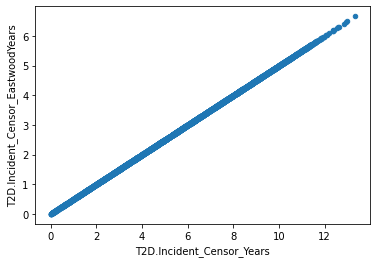

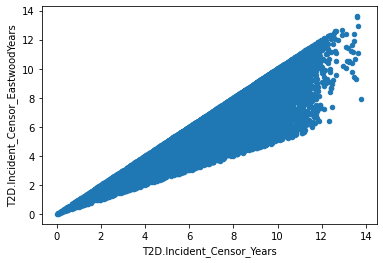

In [53]:
Eastwood_IncidenceDefined[Eastwood_IncidenceDefined['T2D.Incident']==1].groupby('T2D.Incident_PreviousDiabetesFree_Source').plot.scatter('T2D.Incident_Censor_Years', 'T2D.Incident_Censor_EastwoodYears')

T2D.Incident_Censor_Reason
Incident T2D (HES)                                             AxesSubplot(0.125,0.125;0.775x0.755)
No evidence of diabetes (HES) | Incident T2D (Death Record)    AxesSubplot(0.125,0.125;0.775x0.755)
No in-patient data (HES) | Incident T2D (Death Record)         AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

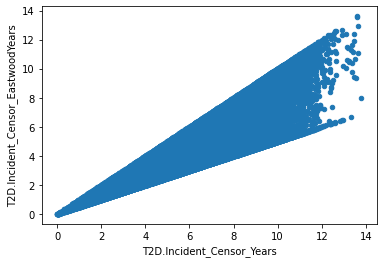

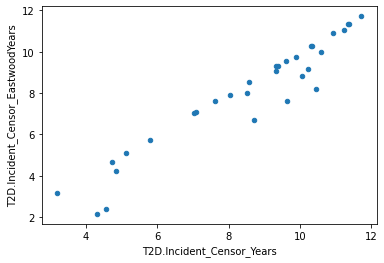

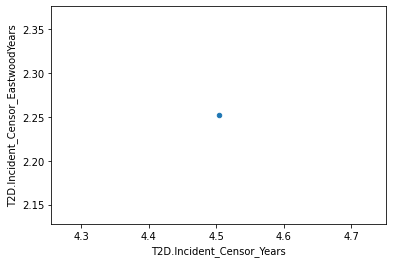

In [54]:
Eastwood_IncidenceDefined[Eastwood_IncidenceDefined['T2D.Incident']==1].groupby('T2D.Incident_Censor_Reason').plot.scatter('T2D.Incident_Censor_Years', 'T2D.Incident_Censor_EastwoodYears')

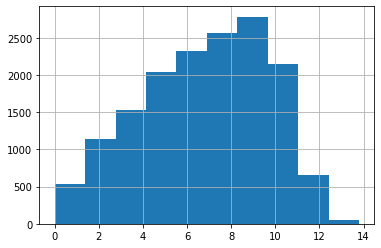

In [55]:
Eastwood_IncidenceDefined.loc[Eastwood_IncidenceDefined['T2D.Incident'.format(disease)] == 1, 'T2D.Incident_Censor_Years'.format(disease)].hist()

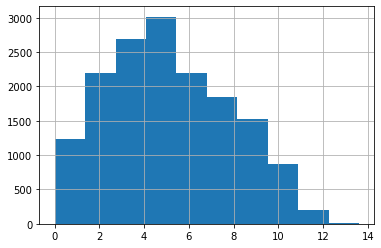

In [56]:
Eastwood_IncidenceDefined.loc[Eastwood_IncidenceDefined['T2D.Incident'.format(disease)] == 1, 'T2D.Incident_Censor_EastwoodYears'.format(disease)].hist()

In [57]:
Eastwood_IncidenceDefined.to_csv('EastwoodDiabetes_IncidentDiabetes.csv')

In [58]:
Eastwood_IncidenceDefined.loc[Eastwood_IncidenceDefined['T2D.Incident'].isnull(), 'diabetes_EastwoodAdjudicated'].value_counts()

Diabetes unlikely                702
Possible gestational diabetes     14
Uncertain diabetes status          8
Name: diabetes_EastwoodAdjudicated, dtype: int64

In [63]:
Eastwood_IncidenceDefined['T2D.Incident'].value_counts(dropna=False)

0.0    460295
1.0     15796
NaN       724
Name: T2D.Incident, dtype: int64

# Extra Checks

In [ ]:
df_Incident = pd.read_csv('EastwoodDiabetes_IncidentDiabetes.csv', index_col=0)
df_Prevalent = pd.read_csv('EastwoodDiabetes_PrevalentDiabetes.csv', index_col=0)

In [ ]:
df_Incident['T2D.Incident'].value_counts(dropna=False)

In [ ]:
df_Incident['T1D.Incident'].value_counts(dropna=False)

In [ ]:
df_Incident['Diabetes_unspecified.Incident'].value_counts(dropna=False)

In [ ]:
df_Incident['T2D.Incident_Censor_Years']

In [ ]:
pd.crosstab(df_Incident['Diabetes_unspecified.Incident_Censor_Reason'], df_Incident['Diabetes_unspecified.Incident'])

In [ ]:
print('Disease', 'Event','Incident_Censor_Years', 'Incident_Censor_EastwoodYears')
for d in ['T2D', 'T1D', 'Diabetes_unspecified']:
    for status, df in df_Incident.groupby('{}.Incident'.format(d)):
        print(d, status, df['{}.Incident_Censor_Years'.format(d)].median(), df['{}.Incident_Censor_EastwoodYears'.format(d)].median())
        
        
        
        

In [ ]:
df_Incident[df_Incident['T2D.Incident']==1].groupby('T2D.Incident_Censor_Reason').plot.scatter('T2D.Incident_Censor_Years', 'T2D.Incident_Censor_EastwoodYears')

In [ ]:
df_Incident['T2D.Incident_Censor_Years'].mean()

In [ ]:
df_Incident.shape

In [64]:
old_Incident = pd.read_csv('OldVersions/EastwoodDiabetes_IncidentDiabetes_NoICD9_June2021.csv', index_col=0)


In [66]:
old_Incident['T2D.Incident'].value_counts(dropna=False)

0.0    460307
1.0     15798
NaN       710
Name: T2D.Incident, dtype: int64

In [88]:
old_Incident.loc[set(Eastwood_IncidenceDefined[Eastwood_IncidenceDefined['T2D.Incident'].isnull()].index).difference(old_Incident[old_Incident['T2D.Incident'].isnull()].index), ['diabetes_EastwoodAdjudicated', 'T2D.Incident', 'T1D.Incident', 'Diabetes_unspecified.Incident']]

,diabetes_EastwoodAdjudicated,T2D.Incident,T1D.Incident,Diabetes_unspecified.Incident
3149954,Diabetes unlikely,1.0,0.0,0.0
1388686,Diabetes unlikely,0.0,0.0,0.0
2900298,Diabetes unlikely,0.0,0.0,0.0
3154327,Diabetes unlikely,0.0,0.0,0.0
5603765,Possible gestational diabetes,0.0,0.0,0.0
2422128,Diabetes unlikely,0.0,0.0,0.0
4941179,Diabetes unlikely,0.0,0.0,0.0
2238534,Diabetes unlikely,0.0,0.0,0.0
1435979,Diabetes unlikely,0.0,0.0,0.0
3869403,Diabetes unlikely,1.0,0.0,0.0


In [87]:
Eastwood_IncidenceDefined

,diabetes_EastwoodAdjudicated,Sex,AgeAtAssessment,DateOfAssessment,centre,dob,ages,country,censor_date.HES,censor_date.Max,...,HES_DiabetesCodes,T2D.Incident_Censor_Years,T2D.Incident_Censor_Date_Adjusted,T2D.Incident_Censor_EastwoodYears,T1D.Incident_Censor_Years,T1D.Incident_Censor_Date_Adjusted,T1D.Incident_Censor_EastwoodYears,Diabetes_unspecified.Incident_Censor_Years,Diabetes_unspecified.Incident_Censor_Date_Adjusted,Diabetes_unspecified.Incident_Censor_EastwoodYears
2998608,Diabetes unlikely,Female,58.0,2010-01-29,11021,1951-09-15,58.374001,England,2020-02-01,2020-02-01,...,0,10.0071,2020-02-01,10.0071,10.0071,2020-02-01,10.0071,10.0071,2020-02-01,10.0071
3528657,Diabetes unlikely,Male,49.0,2009-01-05,11013,1959-08-15,49.394001,England,NaT,2020-02-01,...,0,11.0721,2020-02-01,11.0721,11.0721,2020-02-01,11.0721,11.0721,2020-02-01,11.0721
2536121,Diabetes unlikely,Female,63.0,2008-10-23,11011,1945-08-15,63.189999,England,2020-02-01,2020-02-01,...,0,11.2747,2020-02-01,11.2747,11.2747,2020-02-01,11.2747,11.2747,2020-02-01,11.2747
2326999,Diabetes unlikely,Female,64.0,2010-04-01,11021,1945-10-15,64.459999,England,2020-02-01,2020-02-01,...,0,9.8373,2020-02-01,9.8373,9.8373,2020-02-01,9.8373,9.8373,2020-02-01,9.8373
6022249,Diabetes unlikely,Female,64.0,2009-08-14,11018,1944-08-15,64.997002,England,2020-02-01,2020-02-01,...,1,8.27669,2016-07-09,6.90226,8.27669,2017-11-23,8.27669,8.27669,2017-11-23,8.27669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3218054,Diabetes unlikely,Male,48.0,2009-05-23,11011,1960-10-15,48.602001,England,2020-02-01,2020-02-01,...,0,10.6943,2020-02-01,10.6943,10.6943,2020-02-01,10.6943,10.6943,2020-02-01,10.6943
5962373,Diabetes unlikely,Female,48.0,2009-10-09,11016,1961-08-15,48.151001,England,2020-02-01,2020-02-01,...,0,10.2151,2019-12-27,10.2151,10.2151,2019-12-27,10.2151,10.2151,2019-12-27,10.2151
3577173,Diabetes unlikely,Female,61.0,2008-01-30,11004,1946-06-15,61.625999,Scotland,2020-02-01,2020-02-01,...,0,12.0057,2020-02-01,12.0057,12.0057,2020-02-01,12.0057,12.0057,2020-02-01,12.0057
3014568,Diabetes unlikely,Male,65.0,2009-06-26,11016,1944-02-15,65.361000,England,2020-02-01,2020-02-01,...,0,1.09242,2010-07-30,1.09242,1.09242,2010-07-30,1.09242,1.09242,2010-07-30,1.09242
